# Image Classification Using TensorFlow

## Setup
### Import TensorFlow and other necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and Explore the Datatset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
# Counting the number of images and printing them
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

## Let's take a look at some roses

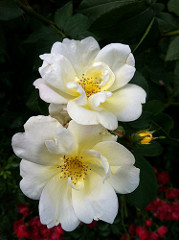

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

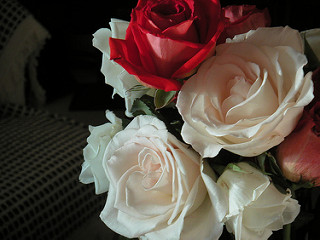

In [5]:
PIL.Image.open(roses[1])

## tulips

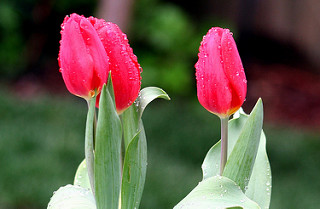

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

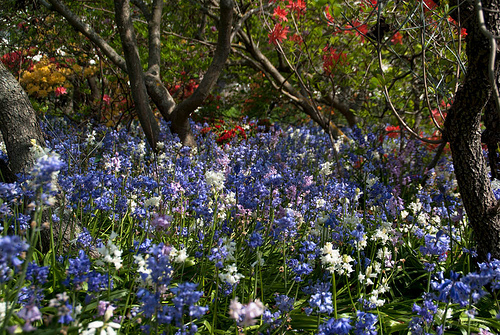

In [7]:
PIL.Image.open(str(tulips[1]))

## Load data using Keras utility
#### Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code

## Create a dataset

In [8]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

### It is a good practice to use validation split when developing your model. Use 80% of your images for training and 20% for validation

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Visualize the Data

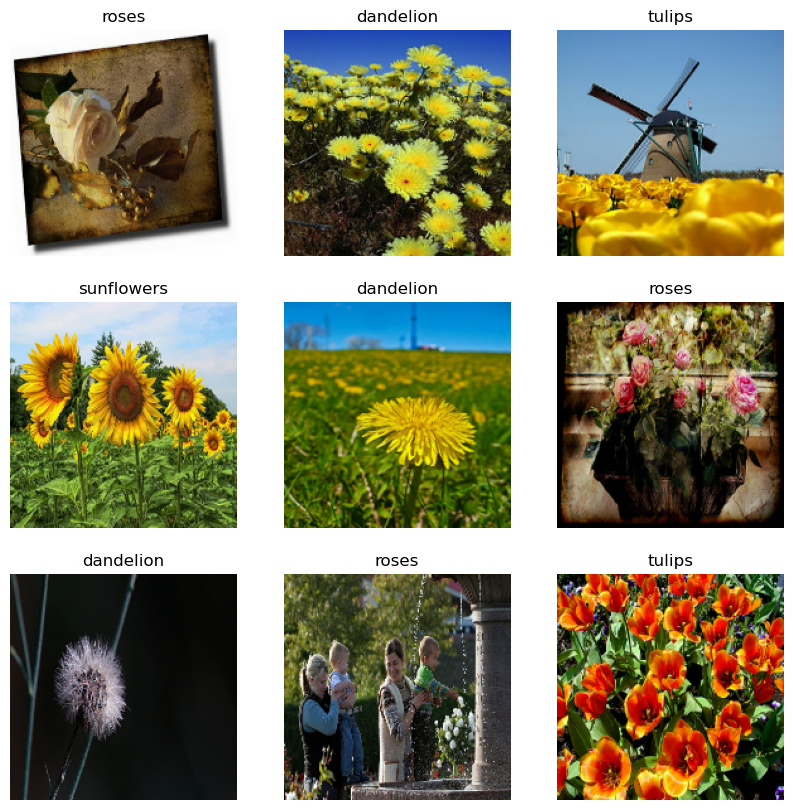

In [12]:
# Here are the first nine images from the training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Configure the Dataset for performance

##### make sure to use bufferd prefetching so you can yield data from the disk without having I/O become blocking. These are two important methods you should use when loading data

##### Dataset.cache - keeps the images in memory after they are loaded off disk during the first epoch.
##### Dataset.prefetch - overlaps data preprocessing and model execution while trainig

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in [0,1]
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.9995425


## A Basic Keras Model
### Create the model

In [17]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the model

In [18]:
model.compile(optimizer = "adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

## Model summary
##### View all the layers of the network usig keras Model.summary method

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

##### Train the model for 10 epochs with the Keras Model.fit method:

In [20]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 147s 2s/step - loss: 1.3763 - accuracy: 0.4142 - val_loss: 1.1940 - val_accuracy: 0.5163
Epoch 2/10
92/92 [==============================] - 144s 2s/step - loss: 0.9576 - accuracy: 0.6294 - val_loss: 0.9730 - val_accuracy: 0.6063
Epoch 3/10
92/92 [==============================] - 149s 2s/step - loss: 0.7932 - accuracy: 0.6941 - val_loss: 0.8934 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 154s 2s/step - loss: 0.5902 - accuracy: 0.7803 - val_loss: 0.9746 - val_accuracy: 0.6580
Epoch 5/10
92/92 [==============================] - 154s 2s/step - loss: 0.3782 - accuracy: 0.8709 - val_loss: 1.0322 - val_accuracy: 0.6771
Epoch 6/10
92/92 [==============================] - 153s 2s/step - loss: 0.2377 - accuracy: 0.9206 - val_loss: 1.3153 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 152s 2s/step - loss: 0.1222 - accuracy: 0.9632 - val_loss: 1.4702 - val_accuracy: 0.6580
Epoch 8/10
92

## Visualize Trainig Results

#### Create plots of loss and accuracy on the training and validation sets

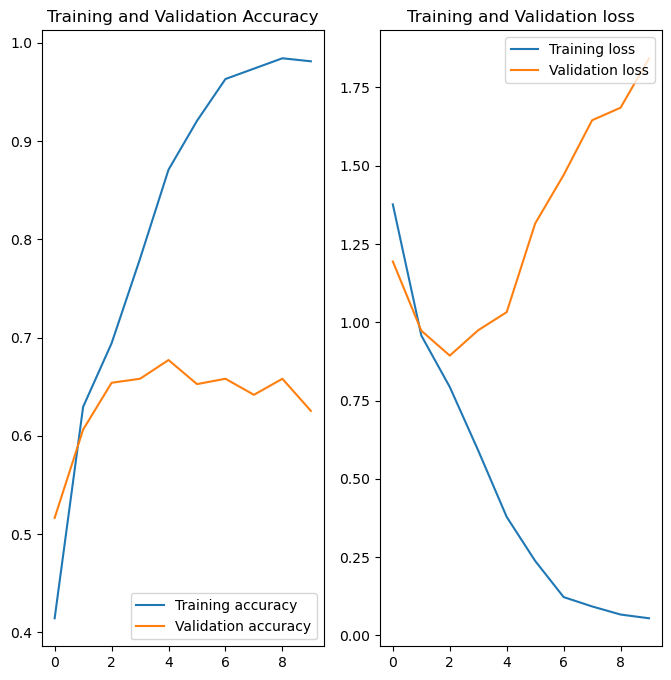

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")
plt.show()

## Overfitting

## Data augmentation

In [22]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
]
)

##### Visualize a few augmented examples by applying data augmentation to the same image several times:

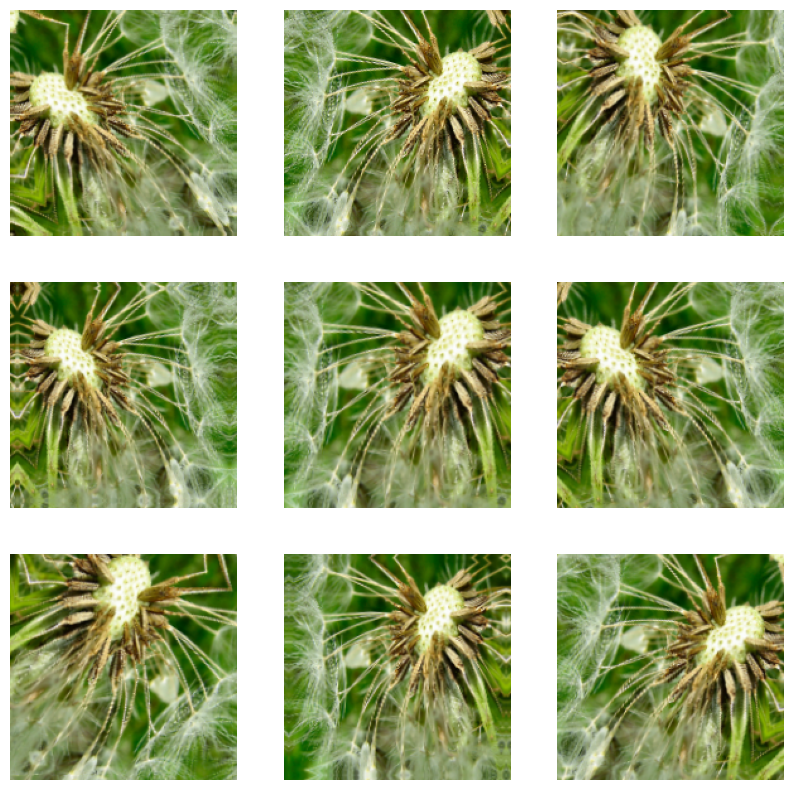

In [23]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### You will add data augmentation to your model before training in the next step.


## Dropout

Another technique to reduce overfitting is to introduce dropout{:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [24]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

## Compile and Train the model

In [25]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 148s 2s/step - loss: 1.3421 - accuracy: 0.4264 - val_loss: 1.1350 - val_accuracy: 0.5300
Epoch 2/15
92/92 [==============================] - 139s 2s/step - loss: 1.0801 - accuracy: 0.5630 - val_loss: 0.9749 - val_accuracy: 0.6158
Epoch 3/15
92/92 [==============================] - 193s 2s/step - loss: 0.9827 - accuracy: 0.6206 - val_loss: 1.0462 - val_accuracy: 0.6281
Epoch 4/15
92/92 [==============================] - 161s 2s/step - loss: 0.8493 - accuracy: 0.6727 - val_loss: 0.9070 - val_accuracy: 0.6526
Epoch 5/15
92/92 [==============================] - 162s 2s/step - loss: 0.7985 - accuracy: 0.6921 - val_loss: 0.8571 - val_accuracy: 0.6689
Epoch 6/15
92/92 [==============================] - 208s 2s/step - loss: 0.7675 - accuracy: 0.7020 - val_loss: 0.7802 - val_accuracy: 0.6935
Epoch 7/15
92/92 [==============================] - 143s 2s/step - loss: 0.6753 - accuracy: 0.7371 - val_loss: 0.7488 - val_accuracy: 0.7030
Epoch 8/15
92

## Visualizing the training results

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

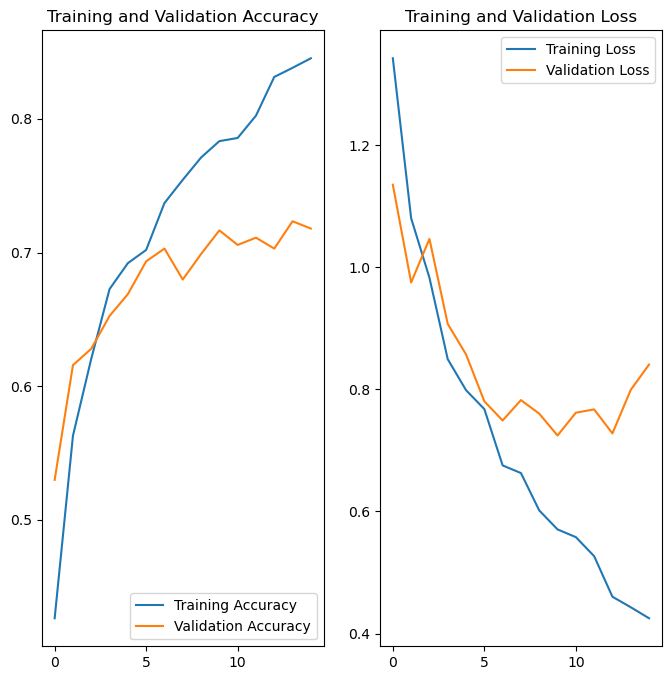

In [28]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


## Predict on New Data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.


In [29]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file("Red_sunflower", origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size = (img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 424ms/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the keras Sequential Model into a TensorFlow Lite model

To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

In this example, take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model

In [30]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmpbbt23mm7\assets


INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmpbbt23mm7\assets


## Run the TensorFlow Lite Model

You can access the TensorFlow Lite saved model signatures in Python via the tf.lite.Interpreter class.

Load the model with the Interpreter:

In [31]:
TF_MODEL_FILE_PATH = 'model.tflite' # the default path to the saved tensorflow lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):

In [32]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called serving_default. In addition, the name of the 'inputs' is 'sequential_1_input', while the 'outputs' are called 'outputs'. You can look up these first and last Keras layer names when running Model.summary, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows:


In [33]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as img_array. Now, pass it to the first argument (the name of the 'inputs') of the loaded TensorFlow Lite model (predictions_lite), compute softmax activations, and then print the prediction for the class with the highest computed probability.


In [34]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [35]:
print(
    'This image most likely belongs to {} with a {:.2f} percent confidence.'
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 100.00 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model

In [36]:
print(np.max(np.abs(predictions - predictions_lite)))

7.6293945e-06


Of the five classes—'daisy', 'dandelion', 'roses', 'sunflowers', and 'tulips'—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.